<a href="https://colab.research.google.com/github/danafaiez/Sarcasm_detection/blob/main/Bi/LSTM_Sarcasm_Classification_NwesDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import spatial
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

auth.authenticate_user()
project_ID ='exalted-amphora-266020'
!gcloud config set project {project_ID}
!gsutil ls


from google.colab import drive
drive.mount('/content/gdrive') 


Updated property [core/project].
gs://test_model_dana/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Sarcasm Detection

### Goal: 

*   Detect sarcasm in text.


### Dataset:

*   [News Headlines Dataset For Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection), collected from two news website:  *TheOnion* which produces sarcastic* versions of current events and *HuffPost*. 

#### Motivation:
  1.   Sarcasm Detection is important for an effectice and accurate sentiment analysis and underatanding of the intention. 

  2.   Sarcasm Detection is especially challenging when working with text data, due to the lack of tone and facial expressions as well as the inherent dependence of sarcasm on the context.

  3. Many previous studies used Twitter dataset for sarcasm detection which have the following disadvantages compared to the News Headlines dataset:

    *   More likely to have spelling mistakes. This reduces the chance of finding pre-trained (meaningful) embeddings for the words.
    *   The Twitter dataset relies on 'sarcasm' hashtangs added by the author. This can add noise to the dataset (labels).

### Procedure:

  1.   Load, clean, and balance the News Headline Dataset
  2.   Prepare data for BERT; get embeddings for the headlines. 
  3.   Prepare data for LSTM.
  4.   Build model.
  5.   Train, hyperparameter tune, and evaluate.







In [ ]:
!pip install transformers
!pip install torch
!pip install torchvision 
!pip install talos
!pip install h5py
!pip install wordcloud

In [3]:

import pandas as pd
import requests
import numpy as np
import string 
import re 
import time

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Flatten, Embedding, Concatenate
from keras import Input


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading and cleaning Dataset

In [4]:
tf.version.VERSION

'2.4.1'

In [5]:
def load_data(n):
  def clean_text(headline):
            #return headline.translate(str.maketrans(dict.fromkeys(string.punctuation))) 
            #headline = re.sub(r"[,.;@_#?!\"&$:]+", ' ', headline) 
            #headline = re.sub(r"\s+", ' ', headline)
            return headline

  srcsm_json = requests.get('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json')
  sentences_clean = []
  labels = []
  i=0
  for item in srcsm_json.json():
      if i<n:
        sentences_clean.append(clean_text(item['headline']))
        labels.append(item['is_sarcastic'])
        i+=1

  df = pd.DataFrame({'text' : sentences_clean[:], 'label':labels[:]})
  # label 0: not-sarcastic; label 1: sarcastic
  return df

In [6]:
####  News Dataset  ####

def balanced_data(df):
  # Make data balanced:

  ## Get the number of sarcastic vs non-sarcastic rows  
  def get_diff_classes(df):  
    count_list = list(df['label'].value_counts())
    return count_list[0]-count_list[1]

  diff = get_diff_classes(df)


  def plot_data_count(df, title):        
    f, ax = plt.subplots(1)
    sns.set_style('whitegrid')
    sns.countplot(x='label',data=df, palette='YlGnBu_r', ax=ax)
    ax.set_xticklabels(["Non-sarcastic","Sarcastic"])
    ax.set(title = title, xlabel='Label', ylabel='Counts')

  if diff !=0:
    plot_data_count(df, 'Counts of non/sarcastic data before balancing')
    print('Before balancing the data, (non-sarcasic - sarcasic) sentences :', get_diff_classes(df))
    if diff>0: datatype = 0 # remove from non-sarcasic class
    else: datatype = 1 # remove from sarcasic class
    np.random.seed(0)
    drop_indices = np.random.choice(df[df['label'] == datatype].index, abs(diff), replace=False)
    df = df.drop(drop_indices)
    print('After balancing the data, (non-sarcasic - sarcasic) sentences :', get_diff_classes(df))
    plot_data_count(df, 'Counts of non/sarcastic data after balancing')

  print("df.info():\n",df.info())
  print("There are", len(df), "total sentences.\n") 
  return df
  

In [7]:
####  Shuffling Dataset  ####
def shuffle_data(df):
  df = df.reindex(np.random.permutation(df.index))
  print("Top 10 sentences and labels:\n", df.head(10))
  return df

In [8]:
def get_sentences_labels(df):
  sentences = df['text'].tolist()
  labels = df['label'].tolist()
  return sentences, labels

### Preparing data for BERT

In [9]:
# bert-base-uncased : 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

##### A quick example:

In [10]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print(tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [11]:
def tokenizer_inptID(sentences):
  
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []

  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start (with ID 101).
      #   (3) Append the `[SEP]` token to the end (with ID 102).
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True, 
                    )
      
      
      input_ids.append(encoded_sent)


  return input_ids

In [12]:
# Get the length of the longest encoded sentence 
def get_max_len(input_ids):
  MAX_LEN = max([len(sen) for sen in input_ids])
  return MAX_LEN

In [13]:
def padding(input_ids, MAX_LEN):

  # Pad our input tokens with value 0.
  # "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                            value=0, truncating="post", padding="post")
  
  
  return input_ids

In [14]:
def Create_segmentsids_attentionmasks(input_ids):
  attention_masks = []
  segments_ids = []
  # For each sentence...
  for id_sent in input_ids:
      
      # Create the attention mask:
      ##  If a token ID is 0, then it's padding, then set the mask to 0 otherwise it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in id_sent]
      # Create the segmentation embeddings:
      segm_id = [0 for token_id in id_sent]
      
      attention_masks.append(att_mask)
      segments_ids.append(segm_id)
  
  
  return attention_masks, segments_ids

In [15]:
def get_embedding(input_ids, segments_ids, attention_masks):
  # Convert the list of IDs to a tensor of IDs 
  #[torch.LongTensor] is an int64 data type value.
  #[torch.Tensor] is a float32 data type value.
  model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=False)
  input_ids_tensor = torch.tensor(input_ids)
  segments_tensors = torch.tensor(segments_ids) 
  attention_tensors = torch.tensor(attention_masks)


  # Set the device to GPU (cuda) if available, otherwise stick with CPU
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = model.to(device)
  input_ids = input_ids_tensor.to(device)
  segments_tensors = segments_tensors.to(device)
  attention_tensors = attention_tensors.to(device)
  # Put the model in "evaluation" mode, meaning feed-forward operation.
  model.eval()
  
  with torch.no_grad():
      outputs = model(input_ids, token_type_ids=segments_tensors, attention_mask=attention_tensors)
      # Transformers models always output tuples.
      # The first element is the hidden state of the last layer of the Bert model
      encoded_layers = outputs[0]
      
  

  
  return encoded_layers

### Preparing embeddings and labels for training/validation process

In [16]:
def split(embedding, labels):
  rand_state = 0

  x_train, x_test, y_train, y_test = train_test_split(embedding, labels, test_size=0.1, random_state=rand_state, stratify=labels)
  x_test, x_val, y_test, y_val     = train_test_split(x_test, y_test, test_size=0.5, random_state=rand_state, stratify=y_test)

  return x_train, y_train, x_val, y_val, x_test, y_test

### Metrics

In [17]:
def confusion(preds, labels):
  tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
  return tn, fp, fn, tp

def get_precision(preds, labels):
  tn, fp, fn, tp = confusion(preds, labels) 
  return tp / (tp + fp)

def get_recall(preds, labels):
  tn, fp, fn, tp = confusion(preds, labels) 
  return tp / (tp + fn)

def get_F1(preds, labels):
  precision = get_precision(preds, labels)
  recall = get_recall(preds, labels)
  F1= 2*(precision*recall)/(precision+recall)
  return F1

def get_accuracy(preds, labels):
  tn, fp, fn, tp = confusion(preds, labels) 
  accuracy = (tn+tp)/(fp+fn+tn+tp)
  return accuracy

### Build model

In [18]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        print("type(units):",type(units))
        print("units:",units)
        self.W1 = tf.keras.layers.Dense(units)
        #print("W1.shape:",self.W1.shape)
        self.W2 = tf.keras.layers.Dense(units)
        #print("W2.shape:",self.W2.shape)
        self.V = tf.keras.layers.Dense(1)
        #print("V.shape:",self.V.shape)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [19]:
def build_model(MAX_LEN, batch_size, epochs, metric, hparams, arch_name):

  if arch_name == 'lstm':
    
    model = Sequential()
    model.add(LSTM(hparams[HP_NUM_UNITS], input_shape=(MAX_LEN,768),return_sequences = False, activation='tanh',recurrent_dropout = hparams[HP_DROPOUT_lstm]))
    #model.add(LSTM(hparams[HP_NUM_UNITS], return_sequences = False, activation='tanh',recurrent_dropout = hparams[HP_DROPOUT_lstm])) 
    model.add(Dropout(hparams[HP_DROPOUT]))
    #model.add(Dense(hparams[HP_NUM_UNITS], activation='tanh'))
    #model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(1, activation="sigmoid"))
    print("weights:\n")
    model.layers[0].get_weights()[0]
    
    
    
  elif arch_name == 'bilstm':
    model = Sequential()
    model.add(Bidirectional(LSTM(hparams[HP_NUM_UNITS], return_sequences=False, activation='tanh', recurrent_dropout = hparams[HP_DROPOUT_lstm]), input_shape=(MAX_LEN,768)))
    #model.add(Bidirectional(LSTM(hparams[HP_NUM_UNITS],return_sequences = False, activation='tanh', recurrent_dropout=0.15)))
    model.add(Dropout(hparams[HP_DROPOUT]))
    #model.add(Dense(50, activation='tanh'))
    #model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(1, activation="sigmoid"))

  
  elif arch_name == 'attention':
    # Bi-directional attention + Attention
    sequence_input = Input(shape=(MAX_LEN,768), batch_size=batch_size)
    #print("sequence_input.shape:",sequence_input.shape)
    lstm = Bidirectional(LSTM(hparams[HP_NUM_UNITS], return_sequences=True, return_state=True, recurrent_activation='tanh', recurrent_dropout = hparams[HP_DROPOUT_lstm]))(sequence_input)
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(hparams[HP_NUM_UNITS], return_sequences = True, return_state=True, activation='tanh',recurrent_dropout = hparams[HP_DROPOUT_lstm]))(lstm)
    #print("(lstm, forward_h.shape, forward_c.shape):",lstm, forward_h.shape, forward_c.shape)

    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    #print("after concatenation:\n")
    #print("state_h.shape, state_c.shape:",state_h.shape, state_c.shape)
    context_vector, attention_weights = Attention(hparams[HP_NUM_UNITS])(lstm, state_h)

    #print("context_vector.shape, attention_weights.shape:", context_vector.shape, attention_weights.shape)
    #dense1 = Dense(50, activation='tanh')(context_vector)
    dropout = Dropout(hparams[HP_DROPOUT])(context_vector) #(dense1)
    output = Dense(1, activation="sigmoid")(dropout)#(context_vector) 
    model = keras.Model(inputs = sequence_input, outputs = output) 
  
  else: raise ValueError("unexpected architecture name: %r" % (arch_name,))
  
  loss = keras.losses.BinaryCrossentropy(from_logits=False)
  optimizer_name = hparams[HP_OPTIMIZER]
  learning_rate = hparams[HP_L_RATE]


  if optimizer_name == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  elif optimizer_name == "AdaDelta":
      optimizer = tf.keras.optimizers.Adadelta(learning_rate = learning_rate, rho=0.9, epsilon=1e-06, name="Adadelta", clipnorm = 1.0) # clipnorm used?
  else:
      raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

  
  model.compile(loss = loss, optimizer = optimizer, metrics = metric)
  model.summary()

 
  
  return model
  

In [20]:
def fit_model(model, x_train, y_train, x_val, y_val, batch_size, epochs, path, logdir, hparams):
              
  
  callbacks = [EarlyStopping(monitor = 'val_accuracy', mode='max', verbose=1, patience=2), 
               ModelCheckpoint(path, monitor = 'val_accuracy', mode='max', verbose=1, save_best_only=True),
               TensorBoard(log_dir=logdir, histogram_freq=1),  
               hp.KerasCallback(logdir, hparams)  
               ]

  # The returned "out_model" object holds a record of the loss values and metric values during training: 
  out_model = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, 
                        epochs = epochs, shuffle=True, callbacks=callbacks, verbose=1)
  
  return out_model
  

In [21]:
def evaluate(model, x_test, y_test, batch_sizem):
  
  print("evaluate on test dataset:\n")
  print("model.evaluate(x_test, y_test, batch_size , verbose=1):",model.evaluate(x_test, y_test, batch_size , verbose=1)) ## check if needed
  loss_test, acc_test, auc_test =  model.evaluate(x_test, y_test, batch_size, verbose=1)
  
  return loss_test, acc_test, auc_test

##  Begin Loading data and training  

In [ ]:

# Getting and cleaning the data 
start_time = time.time()
n =  22692  

df = load_data(n)

df = balanced_data(df)

df = shuffle_data(df)

sentences, labels = get_sentences_labels(df)

print("total number of sentences:", len(sentences))
# Tokenizing 
input_ids = tokenizer_inptID(sentences)
MAX_LEN = get_max_len(input_ids)
print("MAX_LEN:",MAX_LEN)


# Input ID, Segment ID, and attention mask
partition_size = 5000  #250
input_ids_pad = []; start = 0
for i in range(1, 5):
  m = partition_size*i
  input_ids_pad.extend(list(padding(input_ids[start:m], MAX_LEN)))
  start = m
input_ids = np.array(input_ids_pad)

attention_masks, segments_ids = Create_segmentsids_attentionmasks(input_ids)

# Get the embeddings
partition_size = 5000 #250
res = [] ; start = 0
input_ids_list = list(input_ids)

for i in range(1,5):
  m = partition_size*i
  print("start")
  temp = get_embedding(input_ids_list[start:m], segments_ids[start:m], attention_masks[start:m])
  print("Done i:", i)
  res.append(temp)
  start = m

encoded_layers =  torch.cat(res,dim=0)
labels = np.array(labels)


#normalizing data
def normalize(norm_option, embedding):
  input = []
  if norm_option == 'min_max_scaler': #[0,1]
    min_max_scaler = preprocessing.MinMaxScaler()
    embedding = np.array([min_max_scaler.fit_transform(sent) for sent in embedding])

  elif norm_option == 'max_abs_scaler': #[-1,1]  #
    max_abs_scaler = preprocessing.MaxAbsScaler()
    embedding = np.array([max_abs_scaler.fit_transform(sent) for sent in embedding])

  elif norm_option == 'Unit_norm':
    embedding = np.array([preprocessing.normalize(sent, norm='l2') for sent in embedding])
  return embedding 


start_time = time.time()
# metric
metric = [keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')]

####### Hyper param tuning #######

#Clear any logs from previous runs
!rm -rf ./logs/* 

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40])) 
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.70]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['AdaDelta']))
HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([1.0]))
HP_DROPOUT_lstm = hp.HParam('dropout_lsm', hp.Discrete([0.15]))

hp_dict = {'hidden_units' : HP_NUM_UNITS, 'dropout': HP_DROPOUT, 'optimizer': HP_OPTIMIZER, 'lr':HP_L_RATE,'dropout_lstm': HP_DROPOUT_lstm}

batch_size = 32 #20 
epochs = 10


def run(logdir, hparams, xtrain, ytrain, xval, yval, xtest, ytest, path_session, best_weights, eval, arch_name):
  with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    model = build_model(MAX_LEN, batch_size, epochs, metric, hparams, arch_name) 
    dot_img_file = '/content/model_1.png'
    tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)

    if eval==False:
      out_model = fit_model(model, xtrain, ytrain, xval, yval, batch_size, epochs, path_session, logdir, hparams)
      valacc = (out_model.history['val_accuracy'])
      valauc = (out_model.history['val_auc'])
      print('val_acc:', valacc[-1], 'val_auc:', valauc[-1])
      tf.summary.scalar('accuracy', valacc[-1], step = epochs) 
    
    else:  
      model.load_weights(best_weights)
      loss_test, acc_test, auc_test =  model.evaluate(xtest, ytest, batch_size, verbose=1)
      print("loss_test:", loss_test, "acc_test:", acc_test, "auc_test:", auc_test)

      pred = model.predict(xtest)
      #print("pred:",pred)
      print("len of test dataset:", len(pred))
      for thresh in np.linspace(0.3, 0.7, num=5):
        pred_temp = [int(prob > thresh) for prob in pred]      
        
        print("#### Threshold: ####" , thresh)
        (tn, fp, fn, tp) = confusion(pred_temp, ytest)
        print("False predictions of non-sarcasm:", fn)
        print("False predictions of sarcasm:", fp)
        print("True predictions of non-sarcasm:", tn)
        print("True predictions of sarcasm:", tp)

        print("Precision:", get_precision(pred_temp, ytest))
        print("Recall:", get_recall(pred_temp, ytest))
        print("F1:", get_F1(pred_temp, ytest))
        print("Accuracy:", get_accuracy(pred_temp, ytest))
        print('\n')
    return model 
      
    

def run_tensorboard(hp_dict, best_weights, eval, arch_name, norm, norm_options):
  session_num = 0
  for num_units in hp_dict['hidden_units'].domain.values:
    for dropout_rate in hp_dict['dropout'].domain.values: 
        for opt in hp_dict['optimizer'].domain.values:
          for learning_rate in hp_dict['lr'].domain.values:
            for dropout_rate_lstm in hp_dict['dropout_lstm'].domain.values:
                hparams = {
                    HP_NUM_UNITS : num_units,
                    HP_DROPOUT : dropout_rate,
                    HP_OPTIMIZER : opt,
                    HP_L_RATE : learning_rate,
                    HP_DROPOUT_lstm : dropout_rate_lstm, 

                }
                # Preperaing the data for training
                embedding = encoded_layers.numpy() 

                if norm == True:
                  for norm_option in norm_options:
                    print("_____norm_option_____:", norm_option)
                    embedding = normalize(norm_options, embedding)
                    x_train, y_train, x_val, y_val, x_test, y_test = split(embedding, labels)  
                    run_name = "run-%d" % session_num
                    print('---- Starting trial ----: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    path_session = "file_" + str(session_num) + ".hdf5" # Best weights are saved here for each set of hyperparameters
                    model = run('logs/hptune_2/' + run_name, hparams, x_train, y_train, x_val, y_val, x_test, y_test, path_session, best_weights, eval, arch_name)
                    session_num += 1
                    print("\n")
                else:
                  print("_____norm_option_____:" + " not normalizing")
                  x_train, y_train, x_val, y_val, x_test, y_test = split(embedding, labels)  
                  run_name = "run-%d" % session_num
                  print('---- Starting trial ----: %s' % run_name)
                  print({h.name: hparams[h] for h in hparams})
                  path_session = "file_" + str(session_num) + ".hdf5"
                  model = run('logs/hptune_2/' + run_name, hparams, x_train, y_train, x_val, y_val, x_test, y_test, path_session, best_weights, eval, arch_name)
                  session_num += 1
                  print("\n")

  return model
#######  Tune Hyperparameter on Validation Dataset and Save the Best Weights #######
#norm_options = ['min_max_scaler', 'max_abs_scaler','Unit_norm']
model = run_tensorboard(hp_dict, best_weights=None, eval = False, arch_name = 'bilstm', norm = False, norm_options = ['Unit_norm']) #'attention', 'bilstm', 'lstm'
print("time to train/evaluate:\n")
print("%s" % (time.time() - start_time))


_____norm_option_____: not normalizing
---- Starting trial ----: run-0
{'num_units': 40, 'dropout': 0.7, 'optimizer': 'AdaDelta', 'learning_rate': 1.0, 'dropout_lsm': 0.15}
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 80)                258880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 81        
Total params: 258,961
Trainable params: 258,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
563/563 [==============================] - 83s 140ms/step - loss: 0.4654 - accuracy: 0.7738 - auc: 0.8531 - val_loss: 0.3467 - val_accuracy: 0.8440 - val_auc: 0.9447

Epoch 00001: val_accuracy i

In [ ]:
input_ids.shape

(20000, 66)

In [ ]:

%reload_ext tensorboard
%load_ext tensorboard 
%tensorboard --logdir logs/hptune_2


In [ ]:

#######  Evaluating on Test Dataset  #######
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40])) 
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.7])) 
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['AdaDelta']))
HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([1.0]))
HP_DROPOUT_lstm = hp.HParam('dropout_lsm', hp.Discrete([0.15]))

hp_dict_opt = {'hidden_units' : HP_NUM_UNITS, 'dropout': HP_DROPOUT, 'optimizer': HP_OPTIMIZER, 'lr':HP_L_RATE,'dropout_lstm': HP_DROPOUT_lstm}

best_weights = None ## add the file with best weights here
best_weights='/content/file_0.hdf5' 


#model = run_tensorboard(hp_dict_opt, x_train, y_train, x_test, y_test, best_weights, eval = True, arch_name = 'bilstm')
model = run_tensorboard(hp_dict, best_weights=best_weights, eval = True, arch_name = 'bilstm', norm = False, norm_options = ['Unit_norm'])


### Prediction on a sentence

In [ ]:
# Prediction
def prediction(sentence):
  print("tokens:",tokenizer.tokenize(sentence[0]))
  input_ids = tokenizer_inptID(sentence)
  print("input_ids:",input_ids)
  MAX_LEN = 7
  input_ids = padding(input_ids, MAX_LEN)
  attention_masks, segments_ids = Create_segmentsids_attentionmasks(input_ids)
  # Get the embeddings
  embedded_sent = get_embedding(input_ids, segments_ids, attention_masks)
  

  out = embedded_sent.numpy() 
  pred = model.predict(out)
  
  print("pred:", pred)
  if pred[0][0]*100>=50: return "It's a sarcasm"
  else: return "It's not a sarcasm"




s = ["This is a test case"]
prediction(s)


### tf-idf

In [22]:
def get_data_wpunc(n):
  srcsm_json = requests.get('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json')
  sentences_clean = []
  labels = []
  i=0
  for item in srcsm_json.json():
      #if i<n:
        sentences_clean.append(item['headline'])
        labels.append(item['is_sarcastic'])
        i+=1
  df = pd.DataFrame({'text' : sentences_clean[:], 'label':labels[:]})
  print(i)
  return df

def get_sample(m, df):
  #sample_df : a sample of df, inclusing m sarcastic and m snon-sarcastic sentences:
  sample_df = pd.concat([df[df['label'] == 0].sample(m, random_state=1) , df[df['label'] == 1].sample(m,random_state=1)], axis=0)
  print("sample_df:",len(sample_df))
  # all the non-sarcastic sentences joined together, similarly for non-sarcastic sentences
  sample_sentences = sample_df.groupby(['label'])['text'].apply(' '.join).reset_index() 
  documentA = (str(sample_sentences.loc[0,['text']]).split(' ',1)[1]).strip()
  documentB = (str(sample_sentences.loc[1,['text']]).split(' ',1)[1]).strip()

  pd.options.display.max_colwidth = 12441
  #print("documentA:\n", sample_sentences.loc[0,['text']])
  #print("documentA:\n", len(documentA))
  return documentA, documentB

26709
Before balancing the data, (non-sarcasic - sarcasic) sentences : 3261
After balancing the data, (non-sarcasic - sarcasic) sentences : 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23448 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23448 non-null  object
 1   label   23448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
df.info():
 None
There are 23448 total sentences.

sample_df: 23448
d_punc: defaultdict(<class 'list'>, {'?': [585, 91], '!': [135, 31], ':': [1391, 764], ',': [1851, 1424], '-': [1709, 2641], '"': [84, 15]})
len(data): 2


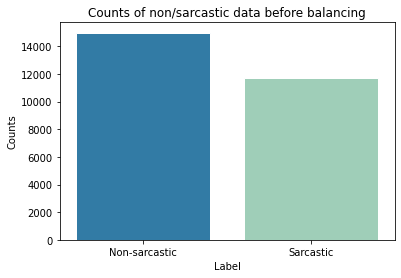

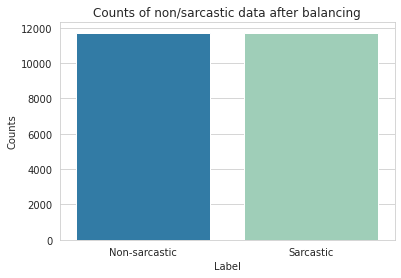

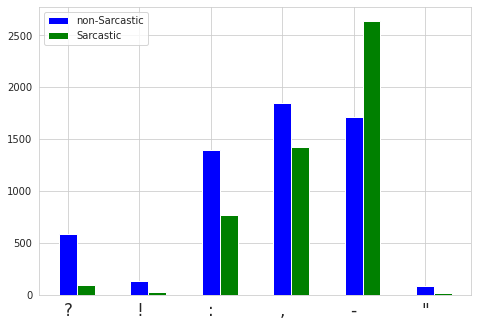

In [23]:

#tf-idf of sample data and punctuation plot
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict


table = str.maketrans(dict.fromkeys(string.punctuation)) 
stopwords = stopwords.words('english')
ps = PorterStemmer() 
  
n = 26709 


df = get_data_wpunc(n)
df = balanced_data(df)
d = df.to_dict("list")
labels = d['label']
sentences_clean = d['text']
m = int(len(df)/2)
documentA, documentB = get_sample(m, df)

def get_punctuation_dict(sentences_clean,labels):
  d_punc = defaultdict(list)
  symbols = "?!:,-\""
  for symbol in symbols:
    count_nc=0; count_c=0
    for i, sent in enumerate(sentences_clean):
      count = sent.count(symbol)
      if labels[i]==0:count_nc+=count
      else:count_c+=count
    d_punc[symbol].append(count_nc)
    d_punc[symbol].append(count_c)

  print("d_punc:", d_punc)

  data = [[list(d_punc.values())[i][0] for i in range(len(symbols))], [list(d_punc.values())[i][1] for i in range(len(symbols))]]
  print("len(data):", len(data))

  # plot
  X = np.arange(6)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(X + 0.00, data[0], color = 'b', width = 0.25, label='non-Sarcastic')
  ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label='Sarcastic')
  labels = ["?","?","!",":",",","-","\""]
  ax.xaxis.set_tick_params(labelsize=17)
  ax.set_xticklabels(labels)
  ax.legend()

#plot punctuation plot
get_punctuation_dict(sentences_clean,labels)

def clean_text(data):
    data = data.translate(table)  
    data = data.lower()
    data = re.sub(r"[,.;@_#?!\"&$:]+", ' ', data) 
    data = re.sub(r"\s+", ' ', data)
    data_split = [ps.stem(w) for w in data.split(' ') if w not in stopwords]
    data = ' '.join(data_split)
    return data, data_split

documentA, bagOfWordsA = clean_text(documentA) # non-sarcastic
documentB, bagOfWordsB = clean_text(documentB) # sarcastic
uniqueWords = set(bagOfWordsA).union(set(bagOfWordsB))

corpus = [documentA, documentB]

vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=1)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
#print(feature_name)

def get_ifidf_for_words(text):
    tfidf_matrix= vectorizer.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    return dict(tfidf_scores)

feature_dict_nc = get_ifidf_for_words(documentA)
feature_dict_nc = {k: v for k, v in sorted(feature_dict_nc.items(), key=lambda item: item[1], reverse=True)}
feature_dict_c = get_ifidf_for_words(documentB)
feature_dict_c = {k: v for k, v in sorted(feature_dict_c.items(), key=lambda item: item[1], reverse=True)}


In [32]:
def word_could(list_words):
    word_could_dict=Counter(list_words)
    print("word_could_dict:",word_could_dict)
    word_could_dict = {k:v for k,v in word_could_dict.items() if v!=0}
    word_could_dict.pop('', None)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")

#### Most important words in non-sarcastic text

In [ ]:
word_could(feature_dict_c)

#### Most important words in sarcastic text:

In [ ]:
word_could(feature_dict_nc)

In [ ]:
c_nc = Counter(bagOfWordsA)
c_nc = {k:v for k,v in c_nc.items() if v!=0}
c_nc.pop('', None)
cA={k: v for k, v in sorted(c_nc.items(), key=lambda item: item[1], reverse=True)}
#print(cA)
word_could(cA)

In [ ]:
c_c = Counter(bagOfWordsB)
c_c = {k:v for k,v in c_c.items() if v!=0}
c_c.pop('', None)
cB={k: v for k, v in sorted(c_c.items(), key=lambda item: item[1], reverse=True)}
#print(cB)
word_could(cB)